In [1]:
from torch.utils.data import DataLoader
from utils import *
from matplotlib import pyplot
import os
from pdb import set_trace

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
print(device)

cuda


In [3]:
torch.set_default_dtype(torch.float64)
# Okay, we kind of have a way of loading the data
# We need to collect the data and feed it to the transformer model
# Now how do we that ?


# Torch Tensor data !
path = './Datasets/intracardiac_dataset/'
VmTrainData, pECGTrainData, VmDataTest, pECGTestData  = fileReader(path, 1000)
print('Data loading from files - complete')

VmTrainData = (VmTrainData - torch.min(VmTrainData))/(torch.max(VmTrainData) - torch.min(VmTrainData))
pECGTrainData = (pECGTrainData - torch.min(pECGTrainData))/(torch.max(pECGTrainData) - torch.min(pECGTrainData))

VmDataTest = (VmDataTest - torch.min(VmDataTest))/(torch.max(VmDataTest) - torch.min(VmDataTest))

pECGTestData = (pECGTestData - torch.min(pECGTestData))/(torch.max(pECGTestData) - torch.min(pECGTestData))
print('Normalization - complete!')

Loading datafiles : 100%|██████████| 1000/1000 [00:00<00:00, 2217.79it/s]


Data loading from files - complete
Normalization - complete!


In [4]:
dim_val = 128
n_heads = 8
n_decoder_layers = 2
n_encoder_layers = 2
input_size = 12
dec_seq_len = 498
enc_seq_len = 500
output_sequence_length = 200
max_seq_len = enc_seq_len
train_batch_size = 16
test_batch_size = 10
batch_first= False
output_size = 75
window_size = 200

In [5]:
from dataset import TransformerDataset
# Get the indices of the sequences
# The idea is: start - stop, where stop - start is window_size
# This means, each tuple in VmInd and pECGInd is 50 steps
datInd = get_indices_entire_sequence(VmData = VmTrainData, 
                                            ECGData = pECGTrainData, 
                                            window_size= window_size, 
                                            step_size = window_size)

# Now let's collect the training data in the Transformer Dataset class
TrainData = TransformerDataset(VmData = VmTrainData,
                                    datInd=datInd,
                                    ECGData = pECGTrainData,
                                    enc_seq_len = enc_seq_len,
                                    dec_seq_len = dec_seq_len,
                                    target_seq_len = output_sequence_length
                                )


TrainData = DataLoader(TrainData, train_batch_size)

datInd = get_indices_entire_sequence(VmData = VmDataTest, 
                                            ECGData = pECGTestData, 
                                            window_size= window_size, 
                                            step_size = window_size)


# Now, let's load the test data
TestData = TransformerDataset(VmData = VmDataTest, 
                                    ECGData = pECGTestData,
                                    datInd=datInd,
                                    enc_seq_len = enc_seq_len,
                                    dec_seq_len = dec_seq_len,
                                    target_seq_len = output_sequence_length
                                )

TestData = DataLoader(TestData, test_batch_size)

In [6]:
from models import TimeSeriesTransformer
model = TimeSeriesTransformer(
    dim_val=dim_val,
    batch_first=batch_first,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads,
    num_predicted_features=output_size
)

# Define the MSE loss
criterion = torch.nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [7]:
EPOCHS= 5
src_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=enc_seq_len
            )
tgt_mask = generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=output_sequence_length
)

for epoch in range(EPOCHS):

    for src, trg, trg_y in TrainData:
        optimizer.zero_grad()
        prediction = model(
            src=src.permute(1,0,2).to(device),
            tgt=trg.permute(0,2,1,3).permute(1,0,2,3).to(device),
            src_mask=src_mask,
            tgt_mask=tgt_mask
            )
        
        loss = criterion(prediction.view_as(trg).to(device), trg_y.to(device))
        loss.backward()
        optimizer.step()
        # scheduler.step()

    print('Epoch: {epoch} Loss: {loss}'.format(epoch=epoch,loss=loss.item()))
        

<bound method Module.train of TimeSeriesTransformer(
  (encoder_input_layer): Linear(in_features=12, out_features=128, bias=True)
  (decoder_input_layer): Linear(in_features=75, out_features=128, bias=True)
  (linear_mapping): Linear(in_features=128, out_features=75, bias=True)
  (positional_encoding_layer): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, 

False
> /home/singhallab/gitProjects/cardiac-ai/models.py(282)forward()
    280 
    281             set_trace()
--> 282             out_tgt = tgt[:,:,0,:]
    283 
    284             for i in range(tgt.shape[2]):



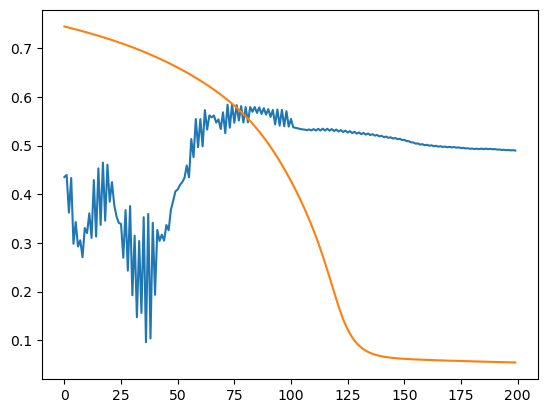

In [10]:

model.train = False
with torch.no_grad():
    src, trg, trg_y = next(iter(TestData))
    prediction = model(
            src=src.permute(1,0,2).to(device),
            tgt=trg.permute(0,2,1,3).permute(1,0,2,3).to(device),
            src_mask=src_mask,
            tgt_mask=tgt_mask
        )
    
    
    pyplot.plot(prediction.view_as(trg_y).reshape(-1,trg_y.shape[1]*trg_y.shape[2] , 75).detach().cpu()[0,:,0])
    pyplot.plot(trg_y.reshape(-1, trg_y.shape[1]*trg_y.shape[2], 75).detach().cpu()[0,:,0])